In [41]:
import pandas as pd
import talib
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import iisignature
from tqdm import tqdm  # For progress bar
from features import construct_features
from signature_feature import create_signature_features 
from sklearn.preprocessing import StandardScaler
from resample import resample


In [42]:
coin_df = pd.read_csv('BNBUSDC-1m-2years.csv') 

In [43]:
coin_df['timestamp'] = pd.to_datetime(coin_df['timestamp'],dayfirst=True )
coin_df.set_index('timestamp', inplace=True)

In [23]:
coin_df = coin_df['2024-04-01':] 

In [24]:
coin_df = resample(coin_df)

In [25]:
coin_df

,close,open,high,low,volume,quote_asset_volume,taker_buy_base_volume,taker_buy_quote_volume,number_of_trades
timestamp,,,,,,,,,
2024-04-01 00:00:00,606.60,606.60,610.50,605.60,899.188,5.457719e+05,350.692,212961.78330,429
2024-04-01 00:15:00,606.80,606.70,607.60,606.50,4.455,2.702838e+03,0.331,201.05460,24
2024-04-01 00:30:00,604.90,607.10,607.10,604.90,7.364,4.468828e+03,0.257,155.85070,32
2024-04-01 00:45:00,605.30,604.90,605.40,604.90,0.933,5.646808e+02,0.790,478.14600,8
2024-04-01 01:00:00,605.80,605.80,606.40,605.60,4.715,2.856862e+03,1.747,1058.47050,13
...,...,...,...,...,...,...,...,...,...
2025-09-30 22:45:00,1003.61,1002.94,1004.51,1001.66,767.000,7.693062e+05,281.106,281968.08840,1839
2025-09-30 23:00:00,1004.31,1003.66,1004.47,1001.67,1230.969,1.234254e+06,500.865,502289.48471,1987
2025-09-30 23:15:00,1006.97,1004.26,1007.22,1003.85,836.411,8.412727e+05,496.437,499405.71452,1407


In [26]:
new_df = construct_features(coin_df)
sig_features = create_signature_features(coin_df, window_size=100, level=2)

new_df = pd.concat([new_df, sig_features], axis=1)

Computing Rolling Signatures (Window: 100, Level: 2)...


100%|██████████| 52508/52508 [00:00<00:00, 267148.45it/s]


In [27]:
new_df = new_df.drop(columns=['Sig_0','Sig_2']) #drop constant features see report for explanation  

In [28]:
print(new_df.head())
new_df.columns.to_list()

                     open_lag_1  high_lag_1  low_lag_1  close_lag_1  \
timestamp                                                             
2024-04-01 00:00:00         NaN         NaN        NaN          NaN   
2024-04-01 00:15:00       606.6       610.5      605.6        606.6   
2024-04-01 00:30:00       606.7       607.6      606.5        606.8   
2024-04-01 00:45:00       607.1       607.1      604.9        604.9   
2024-04-01 01:00:00       604.9       605.4      604.9        605.3   

                     number_of_trades_lag_1  quote_asset_volume_lag_1  \
timestamp                                                               
2024-04-01 00:00:00                     NaN                       NaN   
2024-04-01 00:15:00                   429.0               545771.9419   
2024-04-01 00:30:00                    24.0                 2702.8385   
2024-04-01 00:45:00                    32.0                 4468.8283   
2024-04-01 01:00:00                     8.0                  564

['open_lag_1',
 'high_lag_1',
 'low_lag_1',
 'close_lag_1',
 'number_of_trades_lag_1',
 'quote_asset_volume_lag_1',
 'taker_buy_quote_volume_lag_1',
 'volume_lag_1',
 'HminusL',
 'return_lag_1',
 'return_lag_2',
 'return_lag_3',
 'return_lag_4',
 'return_lag_5',
 'SMA',
 'correlation_sma_close',
 'sum3',
 'sum5',
 'sum3-sum5',
 'target',
 'RSI9',
 'RSI14',
 'RSI9Smaller20',
 'RSI14Smaller20',
 'RSI9Bigger80',
 'MACD1',
 'MACD2',
 'MACD3',
 'roc9',
 'roc14',
 'ewa',
 'mom5',
 'WilliamR',
 'doubleEMA',
 'ATR5',
 'ATR10',
 'aroon_stoch_k',
 'aroon_stoch_d',
 'Sig_1',
 'Sig_3',
 'Sig_4',
 'Sig_5']

In [29]:
new_df.dropna(inplace=True)

In [30]:
Y = new_df['target']
X = new_df.drop(columns = 'target')

In [31]:
from scipy import stats

corr = pd.DataFrame()
corr.index = X.columns
for col in X.columns:
    st = stats.pearsonr(X[col], Y)
    corr.loc[col, 'corr'] = st.statistic
    corr.loc[col, 'pvalue'] = st.pvalue

corr.sort_values(key = lambda x: np.abs(x), by='corr', ascending=False)

,corr,pvalue
RSI9,-0.042485,2.048309e-22
RSI14,-0.042275,3.285370e-22
WilliamR,0.035575,3.512799e-16
sum3,-0.035185,7.335707e-16
MACD1,-0.035074,9.035450e-16
mom5,-0.035050,9.451160e-16
sum5,-0.034481,2.713622e-15
roc14,-0.032751,6.064046e-14
roc9,-0.030732,1.872652e-12
MACD2,-0.028268,9.260848e-11


In [32]:
length = len(coin_df)
print(length)

52608


In [33]:
n1 = int(len(X) * 0.8)
n2 = int(len(X) * 0.9)

X_train, y_train = X[:n1], Y[:n1]
X_eval, y_eval = X[n1:n2], Y[n1:n2]
X_test, y_test = X[n2:], Y[n2:]

In [34]:
sum(y_test==0)/len(y_test)

0.48962102456674916

In [45]:
params={'learning_rate': 0.001,
        'max_depth': 8,
        'n_jobs': -1,
        'early_stopping_round':500,
        'random_state':42,
        'n_estimators':10000,
        #'max_depth':64,
        #'objective': 'accuracy',
        'feature_fraction':0.5,
        #'reg_alpha':100,
        #'max_depth':-1,
        #'reg_lambda':1,
        #'lambda_l2':3.0,        
        #'lambda_l1':0.5,
        'bagging_fraction':0.5,
        'bagging_freq':2,
        'min_data_in_leaf': 20
        #'boosting_type':''
        }
LGBMmodel=LGBMClassifier(**params)
        
LGBMmodel.fit(X_train, y_train, eval_set=[(X_eval, y_eval)])

y_pred = LGBMmodel.predict(X_test)
        
print("LGBM Accuracy: ",accuracy_score(y_test, y_pred))

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 23729, number of neg

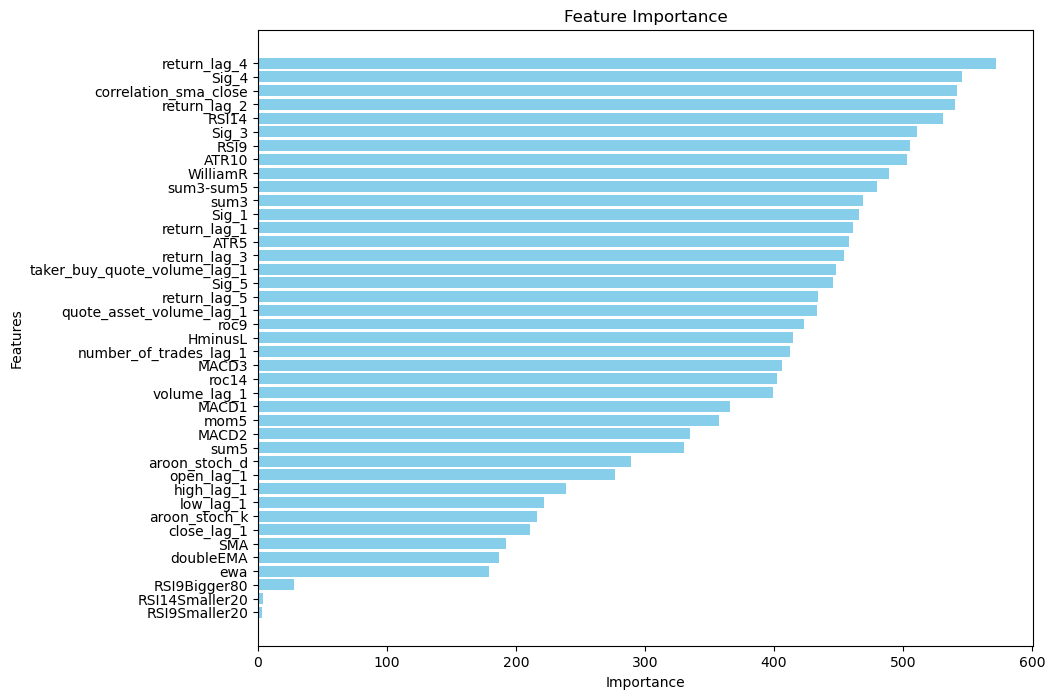

In [36]:
import matplotlib.pyplot as plt

# Extract feature importance from the LightGBM model
feature_importances = LGBMmodel.feature_importances_
features = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Neural Network

In [37]:
from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier
import torch

/opt/anaconda3/envs/mlkaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)

model= TabNetClassifier(optimizer_fn=torch.optim.Adam,
                scheduler_params={"step_size":10, 
                                    "gamma":0.9},
                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                )
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_eval_scaled, y_eval)],
    eval_name=['train', 'validation'],
    eval_metric=['accuracy'],
    max_epochs=500, patience=80,
    batch_size=512, virtual_batch_size=512,
    drop_last=False
)            

X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)
score = accuracy_score(y_test, y_pred)    
print(f"TabNet Score: {score:0.3f}")
#print(f"TabNet OOF Score: {accuracy_score(Y, oof)}")


/opt/anaconda3/envs/mlkaggle/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70984 | train_accuracy: 0.50731 | validation_accuracy: 0.50752 |  0:00:02s
epoch 1  | loss: 0.69428 | train_accuracy: 0.50862 | validation_accuracy: 0.50124 |  0:00:04s
epoch 2  | loss: 0.69436 | train_accuracy: 0.50883 | validation_accuracy: 0.48657 |  0:00:07s
epoch 3  | loss: 0.69371 | train_accuracy: 0.51071 | validation_accuracy: 0.51266 |  0:00:09s
epoch 4  | loss: 0.69342 | train_accuracy: 0.51619 | validation_accuracy: 0.49857 |  0:00:12s
epoch 5  | loss: 0.69324 | train_accuracy: 0.51621 | validation_accuracy: 0.51095 |  0:00:14s
epoch 6  | loss: 0.69296 | train_accuracy: 0.50974 | validation_accuracy: 0.49762 |  0:00:16s
epoch 7  | loss: 0.69314 | train_accuracy: 0.51728 | validation_accuracy: 0.51552 |  0:00:18s
epoch 8  | loss: 0.69312 | train_accuracy: 0.51757 | validation_accuracy: 0.506   |  0:00:21s
epoch 9  | loss: 0.69262 | train_accuracy: 0.52074 | validation_accuracy: 0.50695 |  0:00:23s
epoch 10 | loss: 0.69255 | train_accuracy: 0.52069 | validat

/opt/anaconda3/envs/mlkaggle/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Score: 0.529


## Logistic Regression

In [39]:
n1 = int(len(X) * 0.9)

X_train, y_train = X[:n1], Y[:n1]
X_test, y_test = X[n1:], Y[n1:]

from sklearn.linear_model import LogisticRegressionCV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegressionCV(cv=5, random_state=42, max_iter=5000)#), penalty='l1', solver='liblinear')

print("Training model and tuning C...")
clf.fit(X_train_scaled, y_train)

optimal_c = clf.C_[0]

print("-" * 30)
print(f"Optimal C value found: {optimal_c:.4f}")
print("-" * 30)

y_pred = clf.predict(X_test_scaled)
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")



Training model and tuning C...
------------------------------
Optimal C value found: 0.0001
------------------------------
Test Set Accuracy: 0.5132
